In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from matplotlib.ticker import FixedLocator
from plots.mpltoolkit import named_colors, mpl_loc, fancy_legend, load_mpl_presets
from astropy.cosmology import Planck13 as cosmo
from scipy.integrate import quad
import numpy as np
import sys
sys.path.append("..")
from src.smf import bell03, baldry12
from src.mzr import am2013, zahid2014
from src.umachine_sfhs import umachine_sfh
from src.umachine_sfhs import relative_ia_rate
from src.umachine_sfhs import _MASSES_ as umachine_masses
umachine_masses = list(filter(lambda x: x < 12.3, umachine_masses))
load_mpl_presets()
print(sys.version_info)

/var/home/johnson.7419.local/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=4, releaselevel='final', serial=0)


In [3]:
def shortdelay(t):
    if t >= 0.04:
        return t**-1
    else:
        return 0
    
def exponential(t):
    if t >= 0.15:
        return np.exp(-t / 1.5)
    else:
        return 0

In [2]:
path = "../src/data/umachine-dr1/data/sfhs"
masses = [7.3 + 0.2 * _ for _ in range(30)]
files = ["%s/sfh_sm%.2f_a1.002310.dat" % (path, mass) for mass in masses]
data = {}
for i in range(len(masses)):
    raw = np.genfromtxt(files[i])
    key = "%.2f" % (masses[i])
    data[key] = {}
    data[key]["scale_factor"] = [row[0] for row in raw]
    data[key]["sfh_all"] = [row[1] for row in raw]
    data[key]["sfh_all_+err"] = [row[2] for row in raw]
    data[key]["sfh_all_-err"] = [row[3] for row in raw]
# print(data["7.30"])

In [25]:
cosmo.lookback_time(2).value

10.511840978779919

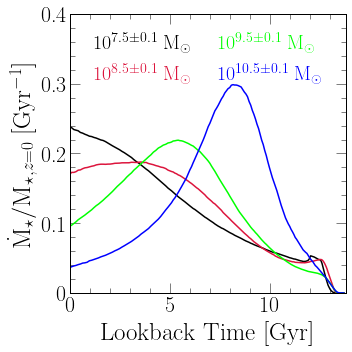

In [3]:
sm = [7.5, 8.5, 9.5, 10.5]
colors = {
    7.5: "black",
    8.5: "crimson",
    9.5: "lime",
    10.5: "blue"
}
prefactor = 1e9
# multipliers = {
#     7.5: 1000,
#     8.5: 100,
#     9.5: 10,
#     10.5: 1
# }

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax.set_xlabel("Lookback Time [Gyr]", fontsize = 25)
# ax.set_ylabel(r"$\propto\dot{\text{M}}_\star$ [M$_\odot$ yr$^{-1}$]", fontsize = 25)
ax.set_ylabel(r"$\dot{\text{M}}_\star / \text{M}_{\star,z=0}$ [Gyr$^{-1}$]", fontsize = 25)
ax.yaxis.set_major_formatter(fsf("%g"))
ax.set_xlim([0, 13.8])
ax.set_ylim([0, 0.4])
# ax.set_yticks([0.1, 0.2, 0.3, 0.4])
# ax.set_xticks([0, 5, 10, 15])
ax.tick_params(labelsize = 22)

for i in range(len(sm)):
    key = "%.2f" % (sm[i])
    z = [1 / _ - 1 for _ in data[key]["scale_factor"]]
    xvals = [cosmo.lookback_time(_).value for _ in z]
#     yvals = [multipliers[sm[i]] * _ for _ in data[key]["sfh_all"]]
    yvals = [prefactor * _ / 10**sm[i] for _ in data[key]["sfh_all"]]
    kwargs = {
        "c": named_colors()[colors[sm[i]]],
        "label": r"$10^{%.1f \pm 0.1}~\text{M}_\odot$" % (sm[i])
    }
    ax.plot(xvals, yvals, **kwargs)
    kwargs = {
        "color": named_colors()[colors[sm[i]]],
        "alpha": 0.3
    }
#     yvals1 = [multipliers[sm[i]] * (a + b) for a, b in zip(data[key]["sfh_all"], data[key]["sfh_all_+err"])]
#     yvals2 = [multipliers[sm[i]] * (a - b) for a, b in zip(data[key]["sfh_all"], data[key]["sfh_all_-err"])]
#     ax.fill_between(xvals, yvals1, yvals2, **kwargs)

kwargs = {
    "loc": mpl_loc("upper left"),
    "handlelength": 0,
    "ncol": 2,
    "fontsize": 20,
    "columnspacing": 1
}
leg = ax.legend(**kwargs)
fancy_legend(leg, [colors[_] for _ in sm])

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/umachine_sfhs.%s" % (ext), **kwargs)
plt.show()

1.00e+12
1.00e+12
1.00e+12
1.00e+12
1.00e+12


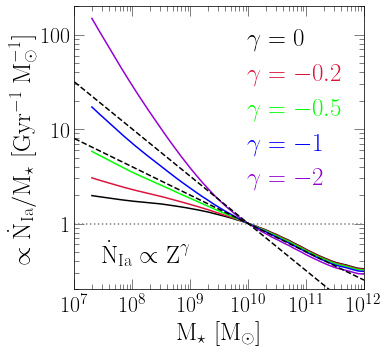

In [8]:
fig = plt.figure(figsize = (5.5, 5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"M$_\star$ [M$_\odot$]", fontsize = 25)
ax.set_ylabel(r"$\propto \dot{\text{N}}_\text{Ia} / \text{M}_\star$ [Gyr$^{-1}$ M$_\odot^{-1}$]", fontsize = 25)
ax.set_xscale("log")
ax.set_yscale("log")
ax.yaxis.set_major_formatter(fsf("%g"))
ax.set_xlim([10**7, 10**12])
ax.set_ylim([0.2, 200])
ax.tick_params(labelsize = 22)
ax.tick_params(axis = "x", pad = 7)
ax.set_xticks([10**_ for _ in range(7, 13)], which = "major")
minorticks = []
for i in range(7, 12):
    for j in range(2, 10):
        minorticks.append(j * 10**i)
ax.xaxis.set_minor_locator(FixedLocator(minorticks))
ax.text(3e7, 0.4, r"$\dot{\text{N}}_\text{Ia} \propto \text{Z}^\gamma$", fontsize = 25)

zscalings = [0, -0.2, -0.5, -1, -2]
colors = ["black", "crimson", "lime", "blue", "darkviolet"]
for i in range(len(zscalings)):
    xvals = np.logspace(7.3, 12, 1001)
    yvals = []
    for j in range(len(xvals)):
        kwargs = {
            "Z": 0.014 * 10**zahid2014(xvals[j], 0),
            "Zscaling_plaw_index": zscalings[i],
        }
        yvals.append(relative_ia_rate(np.log10(xvals[j]), **kwargs)[0] / xvals[j])
        sys.stdout.write("\r%.2e" % (xvals[j]))
    sys.stdout.write("\n")
    kwargs = {
        "c": named_colors()[colors[i]],
        "label": r"$\gamma = %g$" % (zscalings[i])
    }
    pre = 1e10 / relative_ia_rate(10, Z = 0.014 * 10**zahid2014(1e10, 0), Zscaling_plaw_index = zscalings[i])[0]
    yvals = [pre * _ for _ in yvals]
    ax.plot(xvals, yvals, **kwargs)
    
kwargs = {
    "loc": mpl_loc("upper right"),
    "handlelength": 0,
    "fontsize": 25
}
leg = ax.legend(**kwargs)
fancy_legend(leg, colors)

ax.axhline(1, c = named_colors()["grey"], linestyle = ':')

xvals = np.logspace(7, 12, 1000)
yvals = [(_ / 10**10.)**-0.5 for _ in xvals]
kwargs = {
    "c": named_colors()["black"],
    "linestyle": '--'
}
ax.plot(xvals, yvals, **kwargs)
yvals = [(_ / 10**10.)**-0.3 for _ in xvals]
ax.plot(xvals, yvals, **kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/umachine_iarate_metdep.%s" % (ext), **kwargs)
plt.show()

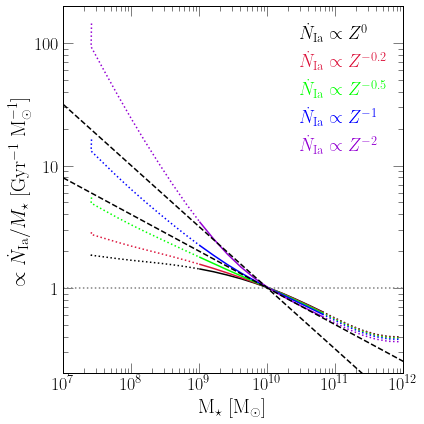

In [13]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111)
ax.set_xlabel(r"M$_\star$ [M$_\odot$]")
ax.set_ylabel(r"$\propto \dot{N}_\text{Ia} / M_\star$ [Gyr$^{-1}$ M$_\odot^{-1}$]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.yaxis.set_major_formatter(fsf("%g"))
ax.set_xlim([10**7, 10**12])
ax.set_ylim([0.2, 200])

# print(umachine_masses)

zscalings = [0, -0.2, -0.5, -1, -2]
colors = ["black", "crimson", "lime", "blue", "darkviolet"]
for i in range(len(zscalings)):
    allmasses = [10**_ for _ in umachine_masses]
#     print(allmasses)
#     lowmasses = list(filter(lambda x: x < 1.e9, allmasses))
#     medmasses = list(filter(lambda x: 1.e9 <= x <= 1.e11, allmasses))
#     highmasses = list(filter(lambda x: x > 1.e11, allmasses))
    masses = []
    yvals = []
    idx = umachine_masses.index(10.1)
    for j in range(len(allmasses)):
        kwargs = {
            "Z": 0.014 * 10**zahid2014(allmasses[j], 0.),
            "Zscaling_plaw_index": zscalings[i],
            "z": 0.,
#             "dtd": exponential
        }
        ria, mstar = relative_ia_rate(umachine_masses[j], **kwargs)
        yvals.append(ria / mstar)
        masses.append(mstar)
#         print(allmasses[j], mstar)
#         if j == idx: print(np.log10(mstar))
#         yvals.append(relative_ia_rate(umachine_masses[j], **kwargs) / xvals[j])
#     print(masses)
    lowmasses = list(filter(lambda x: x < 1.e9, masses))
    medmasses = list(filter(lambda x: 1.e9 <= x <= 1.e11, masses))
    highmasses = list(filter(lambda x: x > 1.e11, masses))
    pre = 1 / yvals[idx]
    yvals = [pre * _ for _ in yvals]
    kwargs = {
        "c": named_colors()[colors[i]],
        "linestyle": ":"
    }
    ax.plot(lowmasses + [medmasses[0]], yvals[:(len(lowmasses) + 1)], **kwargs)
    ax.plot([medmasses[-1]] + highmasses, yvals[-(len(highmasses) + 1):], **kwargs)
    kwargs["linestyle"] = "-"
    kwargs["label"] = r"$\dot{N}_\text{Ia} \propto Z^{%g}$" % (zscalings[i])
    ax.plot(medmasses, yvals[len(lowmasses):-len(highmasses)], **kwargs)
    
kwargs = {
    "loc": mpl_loc("upper right"),
    "handlelength": 0
}
leg = ax.legend(**kwargs)
fancy_legend(leg, colors)
    
ax.axhline(1, c = named_colors()["grey"], linestyle = ':')

xvals = np.logspace(7, 12, 1000)
yvals = [(_ / 10**10.)**-0.5 for _ in xvals]
kwargs = {
    "c": named_colors()["black"],
    "linestyle": '--'
}
ax.plot(xvals, yvals, **kwargs)
yvals = [(_ / 10**10.)**-0.3 for _ in xvals]
ax.plot(xvals, yvals, **kwargs)

plt.tight_layout()
# for ext in ["pdf", "jpeg"]:
#     kwargs = {}
#     if ext == "jpeg": kwargs["dpi"] = 200
#     plt.savefig("umachine_iarate_zahid_z0p0.%s" % (ext), **kwargs)
plt.show()

1.00e+12
1.00e+12
1.00e+12
1.00e+12
1.00e+12
1.00e+12


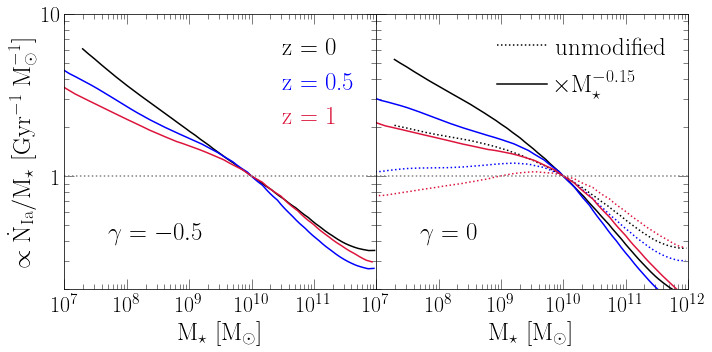

In [18]:
fig = plt.figure(figsize = (10, 5))
axes = []
for i in range(2): axes.append(fig.add_subplot(121 + i))
for ax in axes:
    ax.set_xlabel(r"M$_\star$ [M$_\odot$]", fontsize = 25)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter(fsf("%g"))
    ax.set_xlim([10**7, 10**12])
    ax.set_ylim([0.2, 10])
    ax.tick_params(labelsize = 22)
    ax.tick_params(axis = "x", pad = 7)
    minorticks = []
    for i in range(7, 12):
        for j in range(2, 10):
            minorticks.append(j * 10**i)
    ax.xaxis.set_minor_locator(FixedLocator(minorticks))
axes[0].set_ylabel(r"$\propto \dot{\text{N}}_\text{Ia} / \text{M}_\star$ [Gyr$^{-1}$ M$_\odot^{-1}$]",
    fontsize = 25)
plt.setp(axes[1].get_yticklabels(), visible = False)
axes[0].set_xticks([10**_ for _ in range(7, 12)], which = "major")
axes[1].set_xticks([10**_ for _ in range(7, 13)], which = "major")

# line1 = ax.plot([1e5, 1e6], [1, 10], c = named_colors()["black"], linestyle = '-',
#     label = r"$\gamma = -0.5$")[0]
# line2 = ax.plot([1e5, 1e6], [1, 10], c = named_colors()["black"], linestyle = ':',
#     label = r"$\gamma = 0$")[0]
# kwargs = {
#     "loc": mpl_loc("lower left"),
#     "fontsize": 22,
#     "handlelength": 1.5
# }
# leg2 = ax.legend(**kwargs)
# line1.remove()
# line2.remove()

# redshifts = [1, 0.5, 0]
redshifts = [0, 0.5, 1]
colors = {
    0: "black",
#     0.2: "darkviolet",
#     0.4: "blue",
#     0.6: "green",
#     0.8: "gold",
    0.5: "blue",
    1: "crimson"
}

for z in redshifts:
    allmasses = np.logspace(7.3, 12, 1001)
    masses = []
    yvals = []
    for j in range(len(allmasses)):
        # First compute the stellar mass at the redshift in question
        _, mstar = relative_ia_rate(np.log10(allmasses[j]), z = z)
        # Now evaluate the Zahid et al. (2014) MZR at that mass and at redshift z
        kwargs = {
            "Z": 0.014 * 10**zahid2014(mstar, z),
            "Zscaling_plaw_index": -0.5,
            "z": z
        }
        ria, _ = relative_ia_rate(np.log10(allmasses[j]), **kwargs)
        masses.append(mstar)
        yvals.append(ria / mstar)
        sys.stdout.write("\r%.2e" % (allmasses[j]))
    sys.stdout.write("\n")
    diff = [abs(_ - 1e10) for _ in masses]
    idx = diff.index(min(diff))
    norm = 1 / yvals[idx]
    yvals = [norm * _ for _ in yvals]
#     ria, mstar = relative_ia_rate(10, Z = 0.014 * 10**zahid2014(1e10, z), Zscaling_plaw_index = -0.5, z = z)
#     pre = mstar / ria
#     yvals = [pre * _ for _ in yvals]
    kwargs = {
        "c": named_colors()[colors[z]],
        "label": "z = %g" % (z)
    }
    axes[0].plot(masses, yvals, **kwargs)

    masses = []
    yvals = []
    for j in range(len(allmasses)):
        _, mstar = relative_ia_rate(np.log10(allmasses[j]), z = z)
        kwargs = {
            "Z": 0.014 * 10**zahid2014(mstar, z),
            "Zscaling_plaw_index": 0,
            "z": z,
        }
        ria, _ = relative_ia_rate(np.log10(allmasses[j]), **kwargs)
        masses.append(mstar)
        yvals.append(ria / mstar)
        sys.stdout.write("\r%.2e" % (allmasses[j]))
    sys.stdout.write("\n")
    diff = [abs(_ - 1e10) for _ in masses]
    idx = diff.index(min(diff))
    norm = 1 / yvals[idx]
    yvals = [norm * _ for _ in yvals]
#     ria, mstar = relative_ia_rate(10, Z = 0.014 * 10**zahid2014(1e10, z), Zscaling_plaw_index = 0, z = z)
#     pre = mstar / ria
#     yvals = [pre * _ for _ in yvals]
    kwargs = {
        "c": named_colors()[colors[z]],
        "linestyle": ":"
    }
    if z == 0: kwargs["label"] = "unmodified"
    axes[1].plot(masses, yvals, **kwargs)
    for i in range(len(yvals)): yvals[i] *= (masses[i] / 1e10)**-0.15
    kwargs["linestyle"] = '-'
    if z == 0: kwargs["label"] = r"$\times \text{M}_\star^{-0.15}$"
    axes[1].plot(masses, yvals, **kwargs)

kwargs = {
    "loc": mpl_loc("upper right"),
    "fontsize": 25,
}
axes[1].legend(**kwargs)
kwargs["handlelength"] = 0
leg = axes[0].legend(**kwargs)
fancy_legend(leg, [colors[z] for z in redshifts])
# axes[0].add_artist(leg2)

for ax in axes:
    ax.axhline(1, c = named_colors()["grey"], linestyle = ':')
axes[0].text(5e7, 0.4, r"$\gamma = -0.5$", fontsize = 25)
axes[1].text(5e7, 0.4, r"$\gamma = 0$", fontsize = 25)

plt.tight_layout()
plt.subplots_adjust(wspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/umachine_iarate_redshiftevol.%s" % (ext), **kwargs)
plt.show()

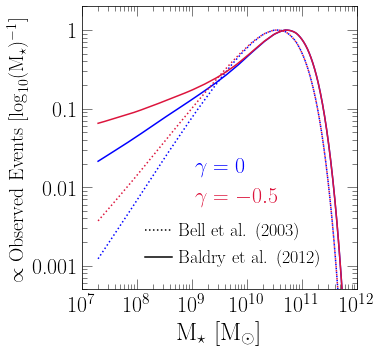

In [6]:
fig = plt.figure(figsize = (5.4, 5))
ax = fig.add_subplot(111)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim([1e7, 1e12])
ax.set_ylim([5e-4, 2])
ax.yaxis.set_major_formatter(fsf("%g"))
ax.set_xlabel(r"M$_\star$ [M$_\odot$]", fontsize = 25)
ax.set_ylabel(r"$\propto$ Observed Events [$\log_{10}$(M$_\star$)$^{-1}$]")
ax.set_xticks([10**_ for _ in range(7, 13)], which = "major")
ax.tick_params(labelsize = 22)
ax.tick_params(axis = "x", pad = 7)
minorticks = []
for i in range(7, 12):
    for j in range(2, 10):
        minorticks.append(j * 10**i)
ax.xaxis.set_minor_locator(FixedLocator(minorticks))

kwargs = {
    "c": named_colors()["black"],
    "linestyle": ":",
    "label": "Bell et al. (2003)"
}
line1 = ax.plot([1e5, 1e6], [1, 10], **kwargs)[0]
kwargs["linestyle"] = "-"
kwargs["label"] = "Baldry et al. (2012)"
line2 = ax.plot([1e5, 1e6], [1, 10], **kwargs)[0]
kwargs = {
    "loc": mpl_loc("lower center"),
    "bbox_to_anchor": (0.55, 0.02),
    "fontsize": 18,
    "handlelength": 1.5
}
leg2 = ax.legend(**kwargs)
line1.remove()
line2.remove()

# masses = [10**_ for _ in umachine_masses]
masses = np.logspace(7.3, 12, 1001)
rates = []
bellrates = []
for i in range(len(masses) - 1):
    rate, mass = relative_ia_rate(np.log10(masses[i]), z = 0)
    norm = quad(baldry12, masses[i], masses[i + 1])[0]
    rates.append(rate * norm)
    norm = quad(bell03, masses[i], masses[i + 1])[0]
    bellrates.append(rate * norm)
# idx = umachine_masses.index(10.1)
# pre = 1 / rates[idx]
# rates = [pre * _ for _ in rates]
# rate, _ = relative_ia_rate(10, z = 0)
# pre = 1. / (rate * quad(baldry12, 10**9.99, 10**10.01)[0])
# rates = [pre * _ for _ in rates]
idx_max = rates.index(max(rates))
norm = 1 / rates[idx_max]
rates = [norm * _ for _ in rates]
idx_max = bellrates.index(max(bellrates))
norm = 1 / bellrates[idx_max]
bellrates = [norm * _ for _ in bellrates]
kwargs = {
    "c": named_colors()["blue"],
    "linestyle": ":"
}
ax.plot(masses[:-1], bellrates, **kwargs)
kwargs["linestyle"] = "-"
kwargs["label"] = r"$\gamma = 0$"
ax.plot(masses[:-1], rates, **kwargs)

rates = []
bellrates = []
for i in range(len(masses) - 1):
    rate, mass = relative_ia_rate(np.log10(masses[i]),
        Zscaling_plaw_index = -0.5, Z = 0.014 * 10**zahid2014(masses[i], 0))
    norm = quad(baldry12, masses[i], masses[i + 1])[0]
    rates.append(rate * norm)
    norm = quad(bell03, masses[i], masses[i + 1])[0]
    bellrates.append(rate * norm)
# idx = umachine_masses.index(10.1)
# pre = 1 / rates[idx]
# rates = [pre * _ for _ in rates]
# rate, _ = relative_ia_rate(10, Zscaling_plaw_index = -0.5, Z = 0.014 * 10**zahid2014(1e10, 0))
# pre = 1. / (rate * quad(baldry12, 10**9.99, 10**10.01)[0])
# rates = [pre * _ for _ in rates]
idx_max = rates.index(max(rates))
norm = 1 / rates[idx_max]
rates = [norm * _ for _ in rates]
idx_max = bellrates.index(max(bellrates))
norm = 1 / bellrates[idx_max]
bellrates = [norm * _ for _ in bellrates]

kwargs = {
    "c": named_colors()["crimson"],
    "linestyle": ":"
}
ax.plot(masses[:-1], bellrates, **kwargs)
kwargs["linestyle"] = "-"
kwargs["label"] = r"$\gamma = -0.5$"
ax.plot(masses[:-1], rates, **kwargs)
    
kwargs = {
    "loc": mpl_loc("lower center"),
    "fontsize": 22,
    "handlelength": 0,
    "bbox_to_anchor": (0.55, 0.22)
}
leg = ax.legend(**kwargs)
fancy_legend(leg, ["blue", "crimson"])
ax.add_artist(leg2)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/ia_massdist.%s" % (ext), **kwargs)
plt.show()

z = 1.00
z = 1.00


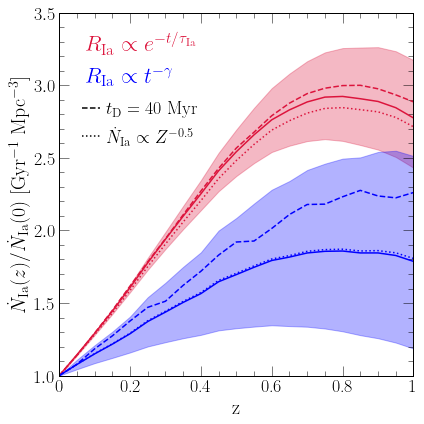

In [24]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111)
ax.set_xlim([0, 1])
ax.set_ylim([1, 3.5])
ax.xaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.xaxis.set_major_formatter(fsf("%g"))
ax.set_xlabel(r"z")
ax.set_ylabel(r"$\dot{N}_\text{Ia}(z) / \dot{N}_\text{Ia}(0)$ [Gyr$^{-1}$ Mpc$^{-3}$]")
    
class exponential:
    
    def __init__(self, timescale, delay = 0.15):
        self.timescale = timescale
        self.delay = delay
        
    def __call__(self, t):
        if t >= self.delay:
            return np.exp(-t / self.timescale)
        else:
            return 0
        

class powerlaw:

    def __init__(self, index, delay = 0.15):
        self.index = index
        self.delay = delay
        
    def __call__(self, t):
        if t >= self.delay:
            return t**-self.index
        else:
            return 0
        
kwargs = {
    "c": named_colors()["black"],
    "linestyle": "--",
    "label": r"$t_\text{D} = 40\text{ Myr}$"
}
line1 = ax.plot([0, 1], [0, 1], **kwargs)[0]
kwargs["linestyle"] = ":"
kwargs["label"] = r"$\dot{N}_\text{Ia} \propto Z^{-0.5}$"
line2 = ax.plot([0, 1], [0, 1], **kwargs)[0]
kwargs = {
    "loc": mpl_loc("upper left"),
    "bbox_to_anchor": (0.02, 0.80),
#     "fontsize": 22,
    "handlelength": 1
}
leg2 = ax.legend(**kwargs)
line1.remove()
line2.remove()

masses = [10**_ for _ in umachine_masses]
redshifts = np.linspace(0, 1, 21)
weights = []
for i in range(len(masses) - 1):
    weights.append(quad(baldry12, masses[i], masses[i + 1])[0])
#     weights[-1] /= (masses[i + 1] - masses[i])

sharps = []
rates = []
shallows = []
shorts = []
zdeps = []
for z in redshifts:
    s1 = s2 = s3 = s4 = s5 = 0
    sharp = exponential(1.2, delay = 0.15)
    standard = exponential(1.5, delay = 0.15)
    shallow = exponential(1.8, delay = 0.15)
    shortdelay = exponential(1.5, delay = 0.04)
    for i in range(len(masses) - 1):
        kwargs = {
            "z": z
        }
        rate, mass = relative_ia_rate(umachine_masses[i], dtd = standard, **kwargs)
        s1 += rate * weights[i]
        rate, mass = relative_ia_rate(umachine_masses[i], dtd = sharp, **kwargs)
        s2 += rate * weights[i]
        rate, mass = relative_ia_rate(umachine_masses[i], dtd = shallow, **kwargs)
        s3 += rate * weights[i]
        rate, mass = relative_ia_rate(umachine_masses[i], dtd = shortdelay, **kwargs)
        s4 += rate * weights[i]
        kwargs["Z"] = 0.014 * 10**zahid2014(masses[i], z)
        kwargs["Zscaling_plaw_index"] = -0.5    
        rate, mass = relative_ia_rate(umachine_masses[i], dtd = standard, **kwargs)
        s5 += rate * weights[i]
    rates.append(s1)
    sharps.append(s2)
    shallows.append(s3)
    shorts.append(s4)
    zdeps.append(s5)
    sys.stdout.write("\rz = %.2f" % (z))
sys.stdout.write("\n")
norm = rates[0]
rates = [_ / norm for _ in rates]
norm = sharps[0]
sharps = [_ / norm for _ in sharps]
norm = shallows[0]
shallows = [_ / norm for _ in shallows]
norm = shorts[0]
shorts = [_ / norm for _ in shorts]
norm = zdeps[0]
zdeps = [_ / norm for _ in zdeps]
kwargs = {
    "color": named_colors()["crimson"]
}
ax.fill_between(redshifts, sharps, shallows, alpha = 0.3, **kwargs)
kwargs["c"] = kwargs["color"]
del kwargs["color"]
ax.plot(redshifts, shorts, linestyle = "--", **kwargs)
ax.plot(redshifts, zdeps, linestyle = ':', **kwargs)
kwargs["label"] = r"$R_\text{Ia} \propto e^{-t/\tau_\text{Ia}}$"
ax.plot(redshifts, rates, **kwargs)

sharps = []
rates = []
shallows = []
shorts = []
zdeps = []
for z in redshifts:
    s1 = s2 = s3 = s4 = s5 = 0
    sharp = powerlaw(1.3, delay = 0.15)
    standard = powerlaw(1, delay = 0.15)
    shallow = powerlaw(0.7, delay = 0.15)
    shortdelay = powerlaw(1, delay = 0.04)
    for i in range(len(masses) - 1):
        kwargs = {
            "z": z
        }
        rate, mass = relative_ia_rate(umachine_masses[i], dtd = standard, **kwargs)
        s1 += rate * weights[i]
        rate, mass = relative_ia_rate(umachine_masses[i], dtd = sharp, **kwargs)
        s2 += rate * weights[i]
        rate, mass = relative_ia_rate(umachine_masses[i], dtd = shallow, **kwargs)
        s3 += rate * weights[i]
        rate, mass = relative_ia_rate(umachine_masses[i], dtd = shortdelay, **kwargs)
        s4 += rate * weights[i]
        kwargs["Z"] = 0.014 * 10**zahid2014(masses[i], z)
        kwargs["Zscaling_plaw_index"] = -0.5    
        rate, mass = relative_ia_rate(umachine_masses[i], dtd = standard, **kwargs)
        s5 += rate * weights[i]
    rates.append(s1)
    sharps.append(s2)
    shallows.append(s3)
    shorts.append(s4)
    zdeps.append(s5)
    sys.stdout.write("\rz = %.2f" % (z))
sys.stdout.write("\n")
norm = rates[0]
rates = [_ / norm for _ in rates]
norm = sharps[0]
sharps = [_ / norm for _ in sharps]
norm = shallows[0]
shallows = [_ / norm for _ in shallows]
norm = shorts[0]
shorts = [_ / norm for _ in shorts]
norm = zdeps[0]
zdeps = [_ / norm for _ in zdeps]
kwargs = {
    "color": named_colors()["blue"]
}
ax.fill_between(redshifts, sharps, shallows, alpha = 0.3, **kwargs)
kwargs["c"] = kwargs["color"]
del kwargs["color"]
ax.plot(redshifts, shorts, linestyle = "--", **kwargs)
ax.plot(redshifts, zdeps, linestyle = ':', **kwargs)
kwargs["label"] = r"$R_\text{Ia} \propto t^{-\gamma}$"
ax.plot(redshifts, rates, **kwargs)

kwargs = {
    "loc": mpl_loc("upper left"),
    "handlelength": 0,
    "fontsize": 22
}
leg = ax.legend(**kwargs)
fancy_legend(leg, ["crimson", "blue"])
ax.add_artist(leg2)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("iarate_zdep.%s" % (ext), **kwargs)
plt.show()

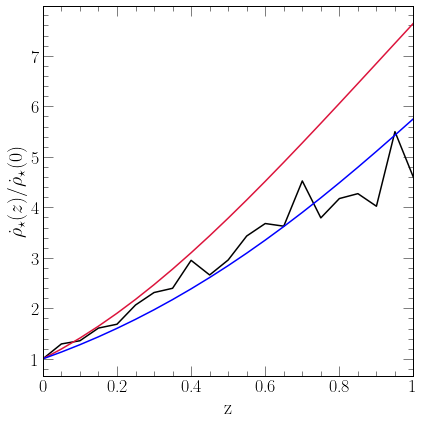

In [19]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111)
ax.set_xlabel("z")
ax.set_ylabel(r"$\dot{\rho}_\star(z) / \dot{\rho}_\star(0)$")
ax.set_xlim([0, 1])
ax.xaxis.set_major_formatter(fsf("%g"))

masses = [10**_ for _ in umachine_masses]
redshifts = np.linspace(0, 1, 21)
weights = []
for i in range(len(masses) - 1):
    weights.append(quad(baldry12, masses[i], masses[i + 1])[0])
    
sfhs = []
md14 = []
mf17 = []
for z in redshifts:
    lookback = cosmo.lookback_time(z).value
    s = 0
    for i in range(len(masses) - 1):
        sfh = umachine_sfh(np.log10(masses[i]))
        s += weights[i] * sfh(lookback)
    sfhs.append(s)
    md14.append(np.exp(lookback / 3.9))
    mf17.append(0.01 * (1 + z)**2.6 / (1 + ((1 + z) / 3.2)**6.2))
norm = sfhs[0]
sfhs = [_ / norm for _ in sfhs]
norm = mf17[0]
mf17 = [_ / norm for _ in mf17]
    
ax.plot(redshifts, sfhs, c = named_colors()["black"])
ax.plot(redshifts, md14, c = named_colors()["crimson"])
ax.plot(redshifts, mf17, c = named_colors()["blue"])

plt.tight_layout()
plt.show()